# Character RNN for SMILES strings

This code builds a Recurrent Neural Network (RNN) model that takes as input a list of SMILES strings 
and learns the type of chemical structures that it has been fed. It can then generate new molecules with
the language it has learned.

## Tokenizing

This block:

- Loads all needed modules/libraries
    
- reads in the datafile containing the SMILES strings
    
* initiates the SMILES tokenizer from the DeepChem library
    
* determines the vocabulary size (see bottom block for customizing vocabulary)
    
* determines the longest SMILES chain, and then pads all shorter chains so that 
    we get uniform length
    
* makes input/target pairs that are each SMILES chain without the last character paired with
the full chain missing the last character.
    
* creates the datasets from the pairs

In [116]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import deepchem as dc
import time
import mordred
import transformers
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

df = pd.read_csv("6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurize

tokenizer=dc.feat.SmilesTokenizer(vocab_file="vocab_new.txt")
featname="SMILES Tokenizer"

fl = list(map(lambda x: tokenizer.encode(x),Xa))

biggest = 1
smallest = 200
for i in range(len(fl)):
    temp = len(fl[i])
    if temp > biggest:
        biggest = temp
    if temp < smallest:
        smallest = temp

print(biggest, smallest)

string_length = smallest - 1
max_length = biggest

fl2 = list(map(lambda x: tokenizer.add_padding_tokens(x,max_length),fl))

fl2set=set()
for sublist in fl2:
    fl2set.update(sublist)
vocab_size = len(fl2set)+1 #add one for unused, original vocab list is 591
print("Vocabulary size for this dataset: ",vocab_size)
print(fl2set)

xlist = [0]*len(fl2)
ylist = [0]*len(fl2)
i=0
for i in range(len(fl2)):
    xlist[i] = fl2[i][0:max_length-1] #string_length
    ylist[i] = fl2[i][1:max_length] #string_length+1
    i += 1

#print("Sample input and target: ")
#print(xlist[5], ylist[5])
#print(xlist[500], ylist[500])
fx = np.array(xlist)
fy = np.array(ylist)
print("Number of features and datapoints, targets: ",fx.shape,fy.shape)
f=fx
#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp=len(df)

#set y to target
y = fy

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:], y=y[:nnp,:], ids=Xa[:nnp], w=w[:nnp])

105 9
Vocabulary size for this dataset:  74
{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
Number of features and datapoints, targets:  (6731, 104) (6731, 104)
featurization done with:  SMILES Tokenizer


## Training the model

- This block defines the sequential model and runs the optimization.

- saves best checkpoints

In [117]:
charRNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=12),
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.Dense(vocab_size,activation="softmax")])

optimizer = tf.keras.optimizers.Nadam()
charRNN.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
model_chkpt = tf.keras.callbacks.ModelCheckpoint("SMILES_rnn",monitor="val_accuracy",save_best_only=True)

history = charRNN.fit(dataset.X,dataset.y,epochs=50,verbose=2,validation_split=0.1,callbacks=[model_chkpt])

Epoch 1/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 37s - loss: 1.4312 - accuracy: 0.6582 - val_loss: 1.4778 - val_accuracy: 0.5653 - 37s/epoch - 194ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 25s - loss: 0.9126 - accuracy: 0.7250 - val_loss: 1.2868 - val_accuracy: 0.6508 - 25s/epoch - 131ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 24s - loss: 0.7251 - accuracy: 0.7737 - val_loss: 1.2068 - val_accuracy: 0.6775 - 24s/epoch - 126ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 24s - loss: 0.6207 - accuracy: 0.8099 - val_loss: 1.1843 - val_accuracy: 0.7031 - 24s/epoch - 127ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 24s - loss: 0.5709 - accuracy: 0.8219 - val_loss: 1.1956 - val_accuracy: 0.7042 - 24s/epoch - 127ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 26s - loss: 0.5353 - accuracy: 0.8299 - val_loss: 1.2276 - val_accuracy: 0.7043 - 26s/epoch - 139ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 23s - loss: 0.5065 - accuracy: 0.8380 - val_loss: 1.2451 - val_accuracy: 0.7069 - 23s/epoch - 120ms/step
Epoch 8/50
190/190 - 26s - loss: 0.4807 - accuracy: 0.8449 - val_loss: 1.2560 - val_accuracy: 0.7002 - 26s/epoch - 136ms/step
Epoch 9/50
190/190 - 28s - loss: 0.4571 - accuracy: 0.8521 - val_loss: 1.2612 - val_accuracy: 0.7020 - 28s/epoch - 148ms/step
Epoch 10/50
190/190 - 30s - loss: 0.4370 - accuracy: 0.8579 - val_loss: 1.2792 - val_accuracy: 0.6944 - 30s/epoch - 160ms/step
Epoch 11/50
190/190 - 27s - loss: 0.4203 - accuracy: 0.8630 - val_loss: 1.2854 - val_accuracy: 0.6981 - 27s/epoch - 144ms/step
Epoch 12/50
190/190 - 31s - loss: 0.4063 - accuracy: 0.8672 - val_loss: 1.2703 - val_accuracy: 0.6965 - 31s/epoch - 165ms/step
Epoch 13/50
190/190 - 29s - loss: 0.3944 - accuracy: 0.8710 - val_loss: 1.2789 - val_accuracy: 0.6989 - 29s/epoch - 153ms/step
Epoch 14/50
190/190 - 31s - loss: 0.3837 - accuracy: 0.8744 - val_loss: 1.2733 - val_accuracy: 0.7008 - 31s/epoch - 163ms/ste

INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 29s - loss: 0.3588 - accuracy: 0.8820 - val_loss: 1.2838 - val_accuracy: 0.7076 - 29s/epoch - 153ms/step
Epoch 18/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 31s - loss: 0.3519 - accuracy: 0.8840 - val_loss: 1.2765 - val_accuracy: 0.7084 - 31s/epoch - 162ms/step
Epoch 19/50
190/190 - 26s - loss: 0.3455 - accuracy: 0.8861 - val_loss: 1.2924 - val_accuracy: 0.7071 - 26s/epoch - 137ms/step
Epoch 20/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 35s - loss: 0.3397 - accuracy: 0.8878 - val_loss: 1.2752 - val_accuracy: 0.7085 - 35s/epoch - 185ms/step
Epoch 21/50
190/190 - 25s - loss: 0.3342 - accuracy: 0.8897 - val_loss: 1.2710 - val_accuracy: 0.7074 - 25s/epoch - 130ms/step
Epoch 22/50
190/190 - 29s - loss: 0.3292 - accuracy: 0.8913 - val_loss: 1.2940 - val_accuracy: 0.7067 - 29s/epoch - 155ms/step
Epoch 23/50
190/190 - 31s - loss: 0.3245 - accuracy: 0.8928 - val_loss: 1.3082 - val_accuracy: 0.7061 - 31s/epoch - 163ms/step
Epoch 24/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 30s - loss: 0.3202 - accuracy: 0.8940 - val_loss: 1.3036 - val_accuracy: 0.7108 - 30s/epoch - 160ms/step
Epoch 25/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 29s - loss: 0.3159 - accuracy: 0.8957 - val_loss: 1.3020 - val_accuracy: 0.7128 - 29s/epoch - 153ms/step
Epoch 26/50
190/190 - 28s - loss: 0.3122 - accuracy: 0.8966 - val_loss: 1.3071 - val_accuracy: 0.7106 - 28s/epoch - 149ms/step
Epoch 27/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 32s - loss: 0.3087 - accuracy: 0.8977 - val_loss: 1.3228 - val_accuracy: 0.7139 - 32s/epoch - 167ms/step
Epoch 28/50
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 31s - loss: 0.3050 - accuracy: 0.8991 - val_loss: 1.3284 - val_accuracy: 0.7175 - 31s/epoch - 161ms/step
Epoch 29/50
190/190 - 25s - loss: 0.3019 - accuracy: 0.9002 - val_loss: 1.3506 - val_accuracy: 0.7128 - 25s/epoch - 132ms/step
Epoch 30/50
190/190 - 30s - loss: 0.2988 - accuracy: 0.9011 - val_loss: 1.3679 - val_accuracy: 0.7093 - 30s/epoch - 157ms/step
Epoch 31/50
190/190 - 31s - loss: 0.2959 - accuracy: 0.9022 - val_loss: 1.3640 - val_accuracy: 0.7123 - 31s/epoch - 162ms/step
Epoch 32/50
190/190 - 32s - loss: 0.2928 - accuracy: 0.9031 - val_loss: 1.3555 - val_accuracy: 0.7162 - 32s/epoch - 167ms/step
Epoch 33/50
190/190 - 29s - loss: 0.2903 - accuracy: 0.9040 - val_loss: 1.3969 - val_accuracy: 0.7138 - 29s/epoch - 153ms/step
Epoch 34/50
190/190 - 31s - loss: 0.2873 - accuracy: 0.9049 - val_loss: 1.4036 - val_accuracy: 0.7141 - 31s/epoch - 163ms/step
Epoch 35/50
190/190 - 31s - loss: 0.2849 - accuracy: 0.9056 - val_loss: 1.4223 - val_accuracy: 0.7124 - 31s/epoch - 163ms/s

INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 35s - loss: 0.2641 - accuracy: 0.9121 - val_loss: 1.4785 - val_accuracy: 0.7196 - 35s/epoch - 182ms/step
Epoch 46/50
190/190 - 27s - loss: 0.2624 - accuracy: 0.9128 - val_loss: 1.5007 - val_accuracy: 0.7125 - 27s/epoch - 140ms/step
Epoch 47/50
190/190 - 27s - loss: 0.2607 - accuracy: 0.9134 - val_loss: 1.5037 - val_accuracy: 0.7182 - 27s/epoch - 144ms/step
Epoch 48/50
190/190 - 28s - loss: 0.2596 - accuracy: 0.9137 - val_loss: 1.5187 - val_accuracy: 0.7101 - 28s/epoch - 149ms/step
Epoch 49/50
190/190 - 31s - loss: 0.2574 - accuracy: 0.9144 - val_loss: 1.5178 - val_accuracy: 0.7149 - 31s/epoch - 161ms/step
Epoch 50/50
190/190 - 28s - loss: 0.2557 - accuracy: 0.9148 - val_loss: 1.5572 - val_accuracy: 0.7119 - 28s/epoch - 147ms/step


## Saves the current model to the current folder

In [118]:
charRNN.save("20Feb_newvocab_embed12",save_format="tf")
print("model saved.")

INFO:tensorflow:Assets written to: 20Feb_newvocab_embed12\assets


INFO:tensorflow:Assets written to: 20Feb_newvocab_embed12\assets


model saved.


## Restart training on saved model

- loads an existing model and restarts training
- requires intial epoch (last epoch from previous training) and new epoch limit

In [119]:
charRNN = tf.keras.models.load_model("20Feb_newvocab_embed12")

optimizer = tf.keras.optimizers.Nadam()
charRNN.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
model_chkpt = tf.keras.callbacks.ModelCheckpoint("SMILES_rnn",monitor="val_accuracy",save_best_only=True)

history = charRNN.fit(dataset.X,dataset.y,epochs=100,initial_epoch=50,verbose=2,validation_split=0.1,callbacks=[model_chkpt])

Epoch 51/100
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 42s - loss: 0.2536 - accuracy: 0.9156 - val_loss: 1.5388 - val_accuracy: 0.7122 - 42s/epoch - 222ms/step
Epoch 52/100
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 23s - loss: 0.2525 - accuracy: 0.9159 - val_loss: 1.5423 - val_accuracy: 0.7141 - 23s/epoch - 120ms/step
Epoch 53/100
190/190 - 20s - loss: 0.2510 - accuracy: 0.9165 - val_loss: 1.5888 - val_accuracy: 0.7127 - 20s/epoch - 104ms/step
Epoch 54/100
190/190 - 21s - loss: 0.2493 - accuracy: 0.9170 - val_loss: 1.5978 - val_accuracy: 0.7121 - 21s/epoch - 112ms/step
Epoch 55/100
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 36s - loss: 0.2486 - accuracy: 0.9171 - val_loss: 1.6027 - val_accuracy: 0.7144 - 36s/epoch - 187ms/step
Epoch 56/100
190/190 - 29s - loss: 0.2468 - accuracy: 0.9177 - val_loss: 1.6171 - val_accuracy: 0.7129 - 29s/epoch - 154ms/step
Epoch 57/100
190/190 - 29s - loss: 0.2459 - accuracy: 0.9180 - val_loss: 1.6342 - val_accuracy: 0.7120 - 29s/epoch - 155ms/step
Epoch 58/100
190/190 - 33s - loss: 0.2454 - accuracy: 0.9181 - val_loss: 1.6330 - val_accuracy: 0.7140 - 33s/epoch - 173ms/step
Epoch 59/100
190/190 - 31s - loss: 0.2437 - accuracy: 0.9187 - val_loss: 1.6234 - val_accuracy: 0.7135 - 31s/epoch - 161ms/step
Epoch 60/100
INFO:tensorflow:Assets written to: SMILES_rnn\assets


INFO:tensorflow:Assets written to: SMILES_rnn\assets


190/190 - 36s - loss: 0.2422 - accuracy: 0.9193 - val_loss: 1.6432 - val_accuracy: 0.7152 - 36s/epoch - 190ms/step
Epoch 61/100
190/190 - 27s - loss: 0.2412 - accuracy: 0.9197 - val_loss: 1.6668 - val_accuracy: 0.7060 - 27s/epoch - 142ms/step
Epoch 62/100
190/190 - 32s - loss: 0.2397 - accuracy: 0.9200 - val_loss: 1.6640 - val_accuracy: 0.7125 - 32s/epoch - 167ms/step
Epoch 63/100
190/190 - 33s - loss: 0.2395 - accuracy: 0.9199 - val_loss: 1.6686 - val_accuracy: 0.7134 - 33s/epoch - 176ms/step
Epoch 64/100
190/190 - 29s - loss: 0.2379 - accuracy: 0.9206 - val_loss: 1.6725 - val_accuracy: 0.7141 - 29s/epoch - 151ms/step
Epoch 65/100
190/190 - 28s - loss: 0.2364 - accuracy: 0.9212 - val_loss: 1.6865 - val_accuracy: 0.7127 - 28s/epoch - 149ms/step
Epoch 66/100
190/190 - 31s - loss: 0.2356 - accuracy: 0.9214 - val_loss: 1.6915 - val_accuracy: 0.7135 - 31s/epoch - 162ms/step
Epoch 67/100
190/190 - 31s - loss: 0.2350 - accuracy: 0.9215 - val_loss: 1.7041 - val_accuracy: 0.7071 - 31s/epoch - 

## Standard molecule prediction

This block

- Takes two strings from the training set (5 and 6 in this case) to use as "seeds"

- Tokenizes the strings
- Makes the input for the predictor by making 2 inputs with **string_length** characters (string_length
is the length of the shortest string in the input. Can be set to any number)
- predictes a new character with the model (the most probable character) and then adds that to the input string,
so that the input is one character longer.
- uses the new input to predict the next chacacter, etc.

In [29]:
charRNN = tf.keras.models.load_model("20Feb_newvocab")

test_string=[""]*2
test_xlist=[0.0]*2

test_string[0] = "CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C"
test_string[1] = "OC[C@H]1O[C@@H](N=C=C2CC(=O)c3c4c2nc2cc(Cl)ccc2c4ncc3)[C@@H]([C@H]([C@@H]1O)O)O"

test_tokenized = list(map(lambda x: tokenizer.encode(x),test_string))
i=0
for i in range(len(test_tokenized)):
    test_xlist[i] = test_tokenized[i][0:string_length]
    i += 1

test_array = np.array(test_xlist)

print("test array: ",test_array)

for i in range(1,30,1):
    results = charRNN.predict(test_array)
    first_proba = results[0,-1]
    second_proba = results[1,-1]
    first_pred = tf.argmax(first_proba)
    second_pred = tf.argmax(second_proba)
    test_xlist[0].append(int(first_pred))
    test_xlist[1].append(int(second_pred))
    test_array = np.array(test_xlist)

new_molecule = tokenizer.decode(test_xlist[0])
new_molecule2 = tokenizer.decode(test_xlist[1])
nm1 = tokenizer.convert_tokens_to_string(new_molecule).replace(" ","")
nm2 = tokenizer.convert_tokens_to_string(new_molecule2).replace(" ","")

print(f"New molecules: {nm1} \n {nm2}.")
print("")

test array:  [[12 16 23 20 16 16 23 17]
 [12 19 16 33 20 19 35 17]]
1/1 [==============================] - 0s 34ms/step
New molecules: [CLS]CN1CCN(CC1)c1ccc(cc1)c1ccc(cc1)c1ccc 
 [CLS]OC[C@H]1O[C@@H]([C@@H]([C@@H]1O)O)OC(=O)c1ccccc1[SEP][PAD][PAD][PAD][PAD][PAD][PAD].



## Temperature-based molecule prediction

This block

- Sets a temperature, which defines how "probable" the next character added to the molecule will be.
- A higher temperature means the next character is less probable.
- Takes two strings from the training set (5 and 6 in this case) to use as "seeds"
- Tokenizes the strings
- Makes the input for the predictor by making 2 inputs with **string_length** characters (string_length
is the length of the shortest string in the input. Can be set to any number)
- predictes a new character with the model (based on the temperature) and then adds that to the input string,
so that the input is one character longer.
- uses the new input to predict the next character, etc.

In [150]:
charRNN = tf.keras.models.load_model("20Feb_newvocab_embed12")

temp = 0.9
tf.random.set_seed(42)

test_string=[""]*2
test_xlist=[0.0]*2

test_string[0] = "CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C"
test_string[1] = "Clc1nnc(c(c1)N1CCN(CC1)CCOc1ccc(cc1)n1cnnc1)Cl"

test_tokenized = list(map(lambda x: tokenizer.encode(x),test_string))
i=0
for i in range(len(test_tokenized)):
    test_xlist[i] = test_tokenized[i][0:string_length]
    i += 1

test_array = np.array(test_xlist)
print("test array: ",test_array)

for i in range(1,80,1):
    results = charRNN.predict(test_array)
    first_proba = results[0,-1:]
    second_proba = results[1,-1:]
    first_rescaled_logits = tf.math.log(first_proba) / temp
    second_rescaled_logits = tf.math.log(second_proba) / temp
    first_pred = tf.random.categorical(first_rescaled_logits,num_samples=1)[0,0]
    second_pred = tf.random.categorical(second_rescaled_logits,num_samples=1)[0,0]
    test_xlist[0].append(int(first_pred))
    test_xlist[1].append(int(second_pred))
    test_array = np.array(test_xlist)

new_molecule = tokenizer.decode(test_xlist[0])
new_molecule2 = tokenizer.decode(test_xlist[1])
nm1 = tokenizer.convert_tokens_to_string(new_molecule).replace(" ","")
nm2 = tokenizer.convert_tokens_to_string(new_molecule2).replace(" ","")

print(f"New molecules: {nm1} \n {nm2}.")
print("")

test array:  [[ 3  6 13 10  6  6 13  7]
 [ 3 18  5 10 15 15  5  7]]
1/1 [==============================] - 0s 53ms/step
New molecules: [CLS]CN1CCN(C)C(=O)N1Cc1ccccc1[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD] 
 [CLS]Clc1nnc(n1C)c1c2cccnc2c2c1ccc(c2)Cl[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD].



## Draw the molecules generated

- Molecules generated in the block above can be visualized here.
- Molecules start after th [CLS] token, and go until the [SEP] or [PAD] token.

[15:22:28] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19


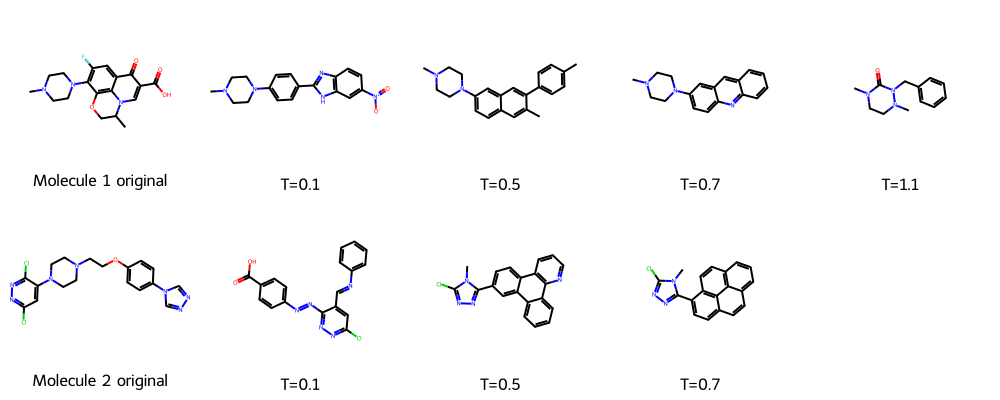

In [151]:
#originals
m1o=Chem.MolFromSmiles("CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C")
m2o=Chem.MolFromSmiles("Clc1nnc(c(c1)N1CCN(CC1)CCOc1ccc(cc1)n1cnnc1)Cl")
#T = 0.1
m1=Chem.MolFromSmiles("CN1CCN(CC1)c1ccc(cc1)c1nc2c([nH]1)cc(cc2)[N+](=O)[O-]")
m2=Chem.MolFromSmiles("Clc1nnc(c(c1)C=Nc1ccccc1)N=Nc1ccc(cc1)C(=O)O")
#T = 0.5
m1t=Chem.MolFromSmiles("CN1CCN(CC1)c1ccc2c(c1)cc(c(c2)C)c1ccc(cc1)C")
m2t=Chem.MolFromSmiles("Clc1nnc(n1C)c1ccc2c(c1)c1ccccc1c1c2cccn1")
#T = 0.7
m1t2=Chem.MolFromSmiles("CN1CCN(CC1)c1ccc2c(c1)cc1c(n2)cccc1")
m2t2=Chem.MolFromSmiles("Clc1nnc(n1C)c1ccc2c3c1ccc1c3c(cc2)ccc1")
#T = 1.1
m1t3=Chem.MolFromSmiles("CN1CCN(C)C(=O)N1Cc1ccccc1")
m2t3=Chem.MolFromSmiles("Clc1nnc(n1C)c1c2cccnc2c2c1ccc(c2)Cl")

leglist = ["Molecule 1 original","T=0.1","T=0.5","T=0.7","T=1.1","Molecule 2 original","T=0.1","T=0.5","T=0.7","T=1.1"]

Draw.MolsToGridImage([m1o,m1,m1t,m1t2,m1t3,m2o,m2,m2t,m2t2,m2t3],molsPerRow=5,legends=leglist)

## Create specific vocab list

- First block must be run before using this block. Then swap out the old vocab file for the new one and rerun
first block.
- reads in original vocab list
- uses the fl2set from the first block: this is a set with all unique tokens used in this model
- if a token is used, it is added to the new vocab list
- Note: [unused] must be added after [PAD] if it is not included

In [108]:
#routine to create a smaller vocab_file based on the dataset using fl2set
oldvocab = open("vocab.txt","r")
oldvocab_lines = oldvocab.readlines()
oldvocab.close()

newvocab = open("vocab_new.txt","w",newline="\n")

for i in range(len(oldvocab_lines)):
    if i in fl2set:
        print(oldvocab_lines[i])
        newvocab.write(oldvocab_lines[i])

newvocab.close()

[PAD]

[UNK]

[CLS]

[SEP]

c

C

(

)

O

1

2

=

N

.

n

3

F

Cl

4

[C@H]

S

[C@@H]

[O-]

Br

#

/

[nH]

[N+]

s

5

o

P

[Si]

I

B

[C@]

[C@@]

6

\

[N-]

[H]

[2H]

[O+]

7

[n+]

[C-]

[B-]

[SiH]

8

[S@]

[S@@]

[NH+]

9

[SiH2]

%10

[n-]

%11

[N]

%12

[o+]

%13

[3H]

%14

%15

%16

%17

%18

%19

%20

%21

%22

%23

%24

